In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score,RandomizedSearchCV,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score,f1_score
from sklearn.linear_model import LogisticRegression
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import shap
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
#Load in data
dogData = pd.read_csv('cleanedDogData.csv', index_col = 'PetID')
catData = pd.read_csv('cleanedCatData.csv', index_col = 'PetID')

In [3]:
dogData.head(3)

,Age,Quantity,Fee,VideoAmt,PhotoAmt,AdoptionSpeed,HasName_0,HasName_1,NameLen,NameNumWords,...,hope,kind,little,lovely,mother,playful,siblings,smart,sweet,trained
PetID,,,,,,,,,,,,,,,,,,,,,
3422e4906,1,1,0,0,7,0,0,1,6,1,...,0,0,0,0,1,0,0,0,0,0
5842f1ff5,4,1,150,0,8,0,0,1,4,1,...,0,0,0,0,0,0,0,0,0,0
850a43f90,1,1,0,0,3,0,0,1,6,1,...,0,0,0,0,0,1,0,0,0,0


In [4]:
dogData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7688 entries, 3422e4906 to a83d95ead
Data columns (total 99 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Age                                       7688 non-null   int64  
 1   Quantity                                  7688 non-null   int64  
 2   Fee                                       7688 non-null   int64  
 3   VideoAmt                                  7688 non-null   int64  
 4   PhotoAmt                                  7688 non-null   int64  
 5   AdoptionSpeed                             7688 non-null   int64  
 6   HasName_0                                 7688 non-null   int64  
 7   HasName_1                                 7688 non-null   int64  
 8   NameLen                                   7688 non-null   int64  
 9   NameNumWords                              7688 non-null   int64  
 10  ThreeMonths_0               

In [5]:
catData.head(3)

,Age,Quantity,Fee,VideoAmt,PhotoAmt,AdoptionSpeed,HasName_0,HasName_1,NameLen,NameNumWords,...,good,healthy,indoor,little,lovely,mother,playful,siblings,sweet,trained
PetID,,,,,,,,,,,,,,,,,,,,,
86e1089a3,3,1,100,0,1,0,0,1,6,1,...,0,0,0,1,0,0,1,0,0,0
6296e909a,1,1,0,0,2,0,0,1,11,3,...,0,0,0,0,0,0,0,0,0,0
d24c30b4b,3,1,0,0,2,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
catData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6576 entries, 86e1089a3 to e4da1c9e4
Columns: 101 entries, Age to trained
dtypes: float64(1), int64(100)
memory usage: 5.1+ MB


Split predictor and response variables into separate dataframes.

In [7]:
X_dog = dogData.drop(columns = 'AdoptionSpeed')
y_dog = dogData.AdoptionSpeed
X_cat = catData.drop(columns = 'AdoptionSpeed')
y_cat = catData.AdoptionSpeed

Split data into train & test.

In [8]:
X_train_dog, X_test_dog, y_train_dog, y_test_dog = train_test_split(X_dog, y_dog, test_size=0.2, random_state=42)
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_cat, test_size=0.2, random_state=42)

In [9]:
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [10]:
final_iv_dog, IV_dog = data_vars(X_train_dog, y_train_dog)
final_iv_cat, IV_cat = data_vars(X_train_cat, y_train_cat)

divide by zero encountered in log
divide by zero encountered in log


In [11]:
# # Remove features with exceptionally low and high information value
features_dog = list(IV_dog[(IV_dog['IV'] >= 0.02) & (IV_dog['IV'] <= 0.8)]['VAR_NAME'])
X2_dog = X_train_dog[features_dog]

features_cat = list(IV_cat[(IV_cat['IV'] >= 0.02) & (IV_cat['IV'] <= 0.8)]['VAR_NAME'])
X2_cat = X_train_cat[features_cat]


In [12]:
pd.set_option('display.max_rows', None)
IV_dog

,VAR_NAME,IV
0,Age,0.229558
1,Breed_103,0.007201
2,Breed_109,0.016278
3,Breed_141,0.009373
4,Breed_179,0.009813
5,Breed_189,0.019414
6,Breed_20,0.020265
7,Breed_205,0.015396
8,Breed_213,0.000103
9,Breed_218,0.014776


In [13]:
pd.set_option('display.max_rows', None)
IV_cat

,VAR_NAME,IV
0,Age,3.976033e-01
1,Breed_243,3.595125e-03
2,Breed_247,9.194034e-04
3,Breed_254,8.994787e-03
4,Breed_264,5.890154e-03
5,Breed_265,1.242153e-04
6,Breed_266,9.129864e-04
7,Breed_283,4.037319e-03
8,Breed_285,1.160926e-02
9,Breed_292,1.192115e-02


In [14]:
list(IV_dog[(IV_dog['IV'] >= 0.02) & (IV_dog['IV'] <= 0.8)]['VAR_NAME'])

['Age',
 'Breed_20',
 'Breed_307',
 'Breed_999',
 'Media_0',
 'Media_1',
 'PhotoAmt',
 'Preparation_0',
 'Preparation_1',
 'PureBreed_0',
 'PureBreed_1',
 'Quantity',
 'RescuerFreq',
 'Rescuer_999',
 'Rescuer_b53c34474d9e24574bcec6a3d3306a0d',
 'Rescuer_c00756f2bdd8fa88fc9f07a8309f7d5d',
 'Rescuer_ee2747ce26468ec44c7194e7d1d9dad9',
 'Rescuer_fa90fa5b1ee11c86938398b60abc32cb',
 'State_41324',
 'State_41326',
 'State_41332',
 'Sterilized_0',
 'Sterilized_1',
 'ThreeMonths_0',
 'ThreeMonths_1']

In [15]:
list(IV_cat[(IV_cat['IV'] >= 0.02) & (IV_cat['IV'] <= 0.8)]['VAR_NAME'])

['Age',
 'DescLen',
 'DescNumWords',
 'Media_0',
 'Media_1',
 'PhotoAmt',
 'Preparation_0',
 'Preparation_1',
 'Quantity',
 'RescuerFreq',
 'Rescuer_999',
 'Rescuer_c00756f2bdd8fa88fc9f07a8309f7d5d',
 'State_41326',
 'Sterilized_0',
 'Sterilized_1',
 'ThreeMonths_0',
 'ThreeMonths_1',
 'Vaccinated_0',
 'Vaccinated_1',
 'eyes',
 'healthy']

###### Looking at the Variance Inflation Factor of the dependent variables.

In [16]:
def iterate_vif(df, vif_threshold=10, max_vif=11):
    count = 0
    while max_vif > vif_threshold:
        count += 1
        print("Iteration # "+str(count))
        vif = pd.DataFrame()
        vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        vif["features"] = df.columns

        if vif['VIFactor'].max() > vif_threshold:
            print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
            df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
            max_vif = vif['VIFactor'].max()
        else:
            print('Complete')
            return df, vif.sort_values('VIFactor')

In [17]:
import warnings
warnings.filterwarnings("ignore")
final_df_dog, final_vif_dog = iterate_vif(X2_dog._get_numeric_data())
final_df_cat, final_vif_cat = iterate_vif(X2_cat._get_numeric_data())

Iteration # 1
Removing Media_0 with VIF of inf
Iteration # 2
Removing Preparation_0 with VIF of inf
Iteration # 3
Removing PureBreed_0 with VIF of inf
Iteration # 4
Removing Sterilized_0 with VIF of inf
Iteration # 5
Removing ThreeMonths_1 with VIF of 53.934296
Iteration # 6
Removing Media_1 with VIF of 25.473668
Iteration # 7
Complete
Iteration # 1
Removing Media_0 with VIF of inf
Iteration # 2
Removing Preparation_0 with VIF of inf
Iteration # 3
Removing Sterilized_0 with VIF of inf
Iteration # 4
Removing ThreeMonths_0 with VIF of inf
Iteration # 5
Removing DescLen with VIF of 116.801742
Iteration # 6
Removing Vaccinated_0 with VIF of 82.652296
Iteration # 7
Removing Media_1 with VIF of 29.405917
Iteration # 8
Complete


In [18]:
X_train_dog = final_df_dog
X_train_cat = final_df_cat

In [19]:
X_test_dog=X_test_dog[X_train_dog.columns]
X_test_cat=X_test_cat[X_train_cat.columns]

In [20]:
X_train_dog.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6150 entries, c22078c20 to 385b5b8fc
Data columns (total 19 columns):
 #   Column                                    Non-Null Count  Dtype
---  ------                                    --------------  -----
 0   Age                                       6150 non-null   int64
 1   Breed_20                                  6150 non-null   int64
 2   Breed_307                                 6150 non-null   int64
 3   Breed_999                                 6150 non-null   int64
 4   PhotoAmt                                  6150 non-null   int64
 5   Preparation_1                             6150 non-null   int64
 6   PureBreed_1                               6150 non-null   int64
 7   Quantity                                  6150 non-null   int64
 8   RescuerFreq                               6150 non-null   int64
 9   Rescuer_999                               6150 non-null   int64
 10  Rescuer_b53c34474d9e24574bcec6a3d3306a0d  6150 non-n

In [21]:
X_train_cat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5260 entries, 66dbc2985 to af862a239
Data columns (total 14 columns):
 #   Column                                    Non-Null Count  Dtype
---  ------                                    --------------  -----
 0   Age                                       5260 non-null   int64
 1   DescNumWords                              5260 non-null   int64
 2   PhotoAmt                                  5260 non-null   int64
 3   Preparation_1                             5260 non-null   int64
 4   Quantity                                  5260 non-null   int64
 5   RescuerFreq                               5260 non-null   int64
 6   Rescuer_999                               5260 non-null   int64
 7   Rescuer_c00756f2bdd8fa88fc9f07a8309f7d5d  5260 non-null   int64
 8   State_41326                               5260 non-null   int64
 9   Sterilized_1                              5260 non-null   int64
 10  ThreeMonths_1                             5260 non-n

Let's test multiple classification models and evaluate the results. 

In [22]:
def model_evaluation(model, params, avg, X_train, X_test, y_train, y_test, prop):
    
    pipe = make_pipeline(StandardScaler(),model)
    model_ran = RandomizedSearchCV(pipe,params,cv=10, n_jobs=-1, scoring = 'roc_auc',random_state = 42)
    model_ran = model_ran.fit(X_train,y_train)
#     y_pred = model_ran.predict(X_test)
    y_pred_proba = model_ran.predict_proba(X_test)[:,1]
    y_pred = np.where(y_pred_proba >= prop, 1, 0)
    f1 = f1_score(y_test, y_pred, average= avg)
    cm = confusion_matrix(y_test, y_pred)
    roc= roc_auc_score(y_test, y_pred_proba)
    print('F1-score: ' , round(f1,4))
    print("Best Score: " , round(model_ran.best_score_,4))
    print("Test ROC AUC:", round(roc,4), '\n')    
    print("Train ROC AUC:", round(roc_auc_score(y_train, model_ran.predict_proba(X_train)[:,1]),4), '\n')
    print("Best Parameters: " , model_ran.best_params_)
    print("Confusion Matrix: " ,'\n', cm, '\n')
    print("Classsification Report: ",'\n', classification_report(y_test, y_pred))
    y_pred_proba=model_ran.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    
    plt.figure()
    plt.plot(fpr, tpr, label='(area = %0.2f)' % roc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

## Logistic regression 

In [23]:
# Logistic regression set up
log_reg_params={'logisticregression__solver':  ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                'logisticregression__penalty': ['none', 'l1','l2','elasticnet'], 
                'logisticregression__C': np.arange(0.05, 100.0, 0.5)}
avg= 'binary'

F1-score:  0.6176
Best Score:  0.7641
Test ROC AUC: 0.797 

Train ROC AUC: 0.7671 

Best Parameters:  {'logisticregression__solver': 'saga', 'logisticregression__penalty': 'l1', 'logisticregression__C': 54.05}
Confusion Matrix:  
 [[815 254]
 [146 323]] 

Classsification Report:  
               precision    recall  f1-score   support

           0       0.85      0.76      0.80      1069
           1       0.56      0.69      0.62       469

    accuracy                           0.74      1538
   macro avg       0.70      0.73      0.71      1538
weighted avg       0.76      0.74      0.75      1538



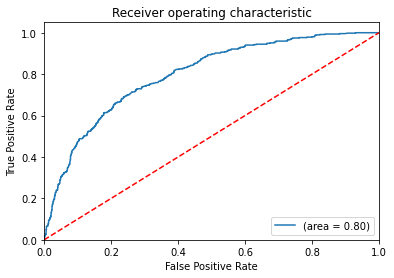

In [24]:
# Logistic regression for dog adoption
log_reg_dog = LogisticRegression()
model_evaluation(log_reg_dog, log_reg_params, avg, X_train_dog, X_test_dog, y_train_dog, y_test_dog, 0.29)

F1-score:  0.522
Best Score:  0.7439
Test ROC AUC: 0.7316 

Train ROC AUC: 0.7481 

Best Parameters:  {'logisticregression__solver': 'saga', 'logisticregression__penalty': 'l2', 'logisticregression__C': 32.05}
Confusion Matrix:  
 [[679 300]
 [112 225]] 

Classsification Report:  
               precision    recall  f1-score   support

           0       0.86      0.69      0.77       979
           1       0.43      0.67      0.52       337

    accuracy                           0.69      1316
   macro avg       0.64      0.68      0.64      1316
weighted avg       0.75      0.69      0.70      1316



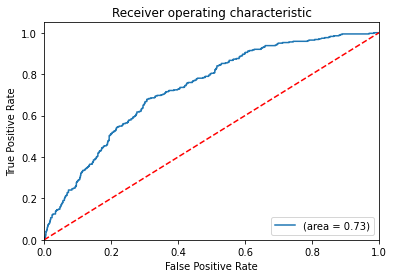

In [25]:
# Logistic regression for cat adoption
log_reg_cat = LogisticRegression()
model_evaluation(log_reg_cat, log_reg_params, avg, X_train_cat, X_test_cat, y_train_cat, y_test_cat, 0.26)

## Random forest

In [26]:
# Random forest set up
params= { 'randomforestclassifier__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 
             'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'], 
             'randomforestclassifier__max_depth' :  np.arange(4,50), 
             'randomforestclassifier__criterion' :['gini', 'entropy'],
            'randomforestclassifier__min_samples_split' : [2, 3, 4]}
avg= 'binary'

F1-score:  0.6553
Best Score:  0.8039
Test ROC AUC: 0.8355 

Train ROC AUC: 0.9212 

Best Parameters:  {'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__min_samples_split': 4, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 13, 'randomforestclassifier__criterion': 'gini'}
Confusion Matrix:  
 [[750 319]
 [ 85 384]] 

Classsification Report:  
               precision    recall  f1-score   support

           0       0.90      0.70      0.79      1069
           1       0.55      0.82      0.66       469

    accuracy                           0.74      1538
   macro avg       0.72      0.76      0.72      1538
weighted avg       0.79      0.74      0.75      1538



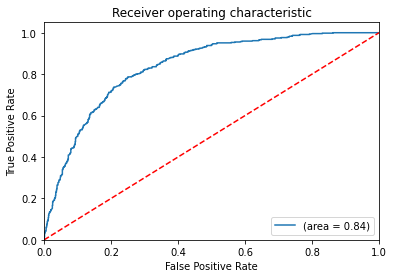

In [27]:
# Random forest for dog adoption
rf_dog = RandomForestClassifier()
model_evaluation(rf_dog, params, avg, X_train_dog, X_test_dog, y_train_dog, y_test_dog, 0.29)

F1-score:  0.5355
Best Score:  0.7761
Test ROC AUC: 0.7725 

Train ROC AUC: 0.8704 

Best Parameters:  {'randomforestclassifier__n_estimators': 1400, 'randomforestclassifier__min_samples_split': 3, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__max_depth': 9, 'randomforestclassifier__criterion': 'gini'}
Confusion Matrix:  
 [[646 333]
 [ 92 245]] 

Classsification Report:  
               precision    recall  f1-score   support

           0       0.88      0.66      0.75       979
           1       0.42      0.73      0.54       337

    accuracy                           0.68      1316
   macro avg       0.65      0.69      0.64      1316
weighted avg       0.76      0.68      0.70      1316



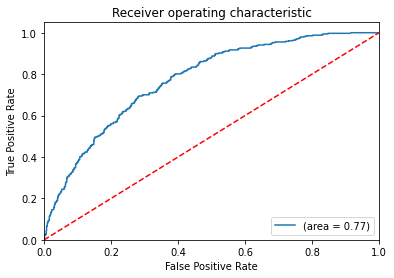

In [28]:
# Random forest for cat adoption
rf_cat = RandomForestClassifier()
model_evaluation(rf_cat, params, avg, X_train_cat, X_test_cat, y_train_cat, y_test_cat, 0.26)

## XGBoost 

In [29]:
params= {'xgbclassifier__nthread':[10], #when use hyperthread, xgboost may become slower
              'xgbclassifier__objective':['binary:logistic'],
              'xgbclassifier__learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05], #so called `eta` value
              'xgbclassifier__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
              'xgbclassifier__min_child_weight':range(1,6) ,
              'xgbclassifier__silent': [1],
              'xgbclassifier__subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
              'xgbclassifier__colsample_bytree':[0.5, 0.6, 0.7, 0.8, 0.9],
              'xgbclassifier__n_estimators': [1000],
             'xgbclassifier__seed': [27]
            }            
avg= 'binary'

[22:42:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:42:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1-score:  0.5803
Best Score:  0.813
Test ROC AUC: 0.8433 

Train ROC AUC: 0.8843 

Best Parameters:  {'xgbclassifier__subsample': 0.5, 'xgbclassifier__silent': 1, 'xgbclassifier__seed': 27, 'xgbclassifier__objective': 'binary:logistic', 'xgbclassifier__nthread': 10, 'xgbclassifier__n_estimators': 1000, 'xgbclassifier__min_child_weight': 2, 'xgbclassifier__m

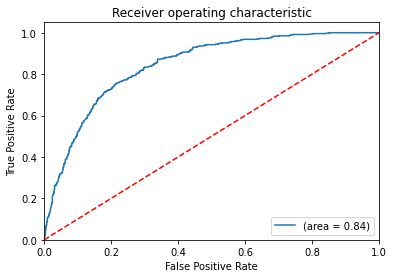

In [30]:
# XGBoost for dog adoption
xgb_dog = xgb.XGBClassifier()
model_evaluation(xgb_dog, params, avg, X_train_dog, X_test_dog, y_train_dog, y_test_dog, 0.29)

[22:45:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:45:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1-score:  0.4781
Best Score:  0.7687
Test ROC AUC: 0.7717 

Train ROC AUC: 0.8826 

Best Parameters:  {'xgbclassifier__subsample': 0.7, 'xgbclassifier__silent': 1, 'xgbclassifier__seed': 27, 'xgbclassifier__objective': 'binary:logistic', 'xgbclassifier__nthread': 10, 'xgbclassifier__n_estimators': 1000, 'xgbclassifier__min_child_weight': 4, 'xgbclassifier__

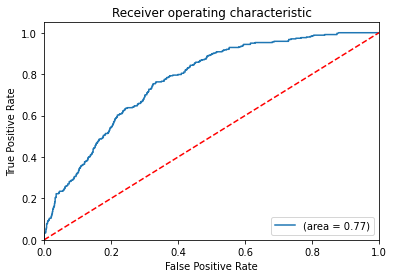

In [31]:
# XGBoost for cat adoption
xgb_cat = xgb.XGBClassifier()
model_evaluation(xgb_cat, params, avg, X_train_cat, X_test_cat, y_train_cat, y_test_cat, 0.26)

Random forest yields the best model with an AUC score of 0.79 for dogs and 0.75 for cats.  

## Best model

### Fit best model to dog adoption data

F1-score:  0.658
ROC AUC: 0.8363 

Confusion Matrix:  
 [[765 304]
 [ 90 379]] 

Classsification Report:  
               precision    recall  f1-score   support

           0       0.89      0.72      0.80      1069
           1       0.55      0.81      0.66       469

    accuracy                           0.74      1538
   macro avg       0.72      0.76      0.73      1538
weighted avg       0.79      0.74      0.75      1538



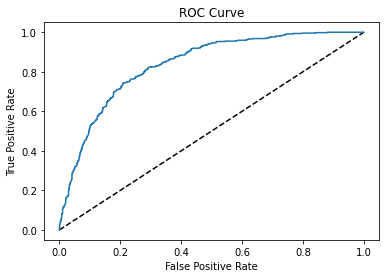

In [32]:
best_params = {'n_estimators': 200, 'min_samples_split': 4, 'max_features': 'sqrt', 'max_depth': 13, 'criterion': 'gini'}
model_dog = RandomForestClassifier(random_state = 27, **best_params)
model_dog.fit(X_train_dog, y_train_dog)
# y_pred_dog = model_dog.predict(X_test_dog)
y_pred_proba_dog = model_dog.predict_proba(X_test_dog)[:,1]
y_pred_dog = np.where(y_pred_proba_dog >= 0.29, 1, 0)
f1 = f1_score(y_test_dog, y_pred_dog, average= 'binary')
cm = confusion_matrix(y_test_dog, y_pred_dog)
roc= roc_auc_score(y_test_dog, y_pred_proba_dog)
print('F1-score: ' , round(f1,4))
print("ROC AUC:", round(roc,4), '\n')
print("Confusion Matrix: " ,'\n', cm, '\n')
print("Classsification Report: ",'\n', classification_report(y_test_dog, y_pred_dog))
fpr, tpr, thresholds = roc_curve(y_test_dog, y_pred_proba_dog)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label= 'f"{model}" ')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

### Fit best model to cat adoption data

F1-score:  0.5371
ROC AUC: 0.7741 

Confusion Matrix:  
 [[646 333]
 [ 91 246]] 

Classsification Report:  
               precision    recall  f1-score   support

           0       0.88      0.66      0.75       979
           1       0.42      0.73      0.54       337

    accuracy                           0.68      1316
   macro avg       0.65      0.69      0.65      1316
weighted avg       0.76      0.68      0.70      1316



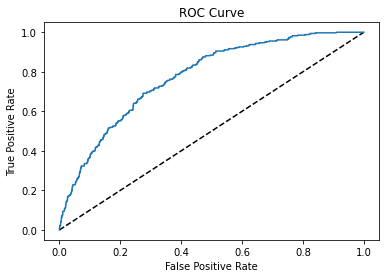

In [33]:
best_params = {'n_estimators': 1400, 'min_samples_split': 3, 'max_features': 'auto', 'max_depth': 9, 'criterion': 'gini'}
model_cat = RandomForestClassifier(random_state = 27, **best_params)
model_cat.fit(X_train_cat, y_train_cat)
# y_pred_cat = model_cat.predict(X_test_cat)
y_pred_proba_cat = model_cat.predict_proba(X_test_cat)[:,1]
y_pred_cat = np.where(y_pred_proba_cat >= 0.26, 1, 0)
f1 = f1_score(y_test_cat, y_pred_cat, average= 'binary')
cm = confusion_matrix(y_test_cat, y_pred_cat)
roc= roc_auc_score(y_test_cat, y_pred_proba_cat)
print('F1-score: ' , round(f1,4))
print("ROC AUC:", round(roc,4), '\n')
print("Confusion Matrix: " ,'\n', cm, '\n')
print("Classsification Report: ",'\n', classification_report(y_test_cat, y_pred_cat))
fpr, tpr, thresholds = roc_curve(y_test_cat, y_pred_proba_cat)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr,label= 'f"{model}" ')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## Feature importance

### Feature importance for dog adoption

In [34]:
feature_importance = model_dog.feature_importances_
df= pd.DataFrame({'feature':X_train_dog.columns,'importance':feature_importance}).sort_values('importance',ascending=False)
df_new=df.sort_values(by=['importance'], ascending=False)
df_new

,feature,importance
8,RescuerFreq,0.210520
0,Age,0.187022
4,PhotoAmt,0.154147
2,Breed_307,0.082276
7,Quantity,0.072553
18,ThreeMonths_0,0.047721
6,PureBreed_1,0.046282
9,Rescuer_999,0.030182
15,State_41326,0.028168
17,Sterilized_1,0.027835


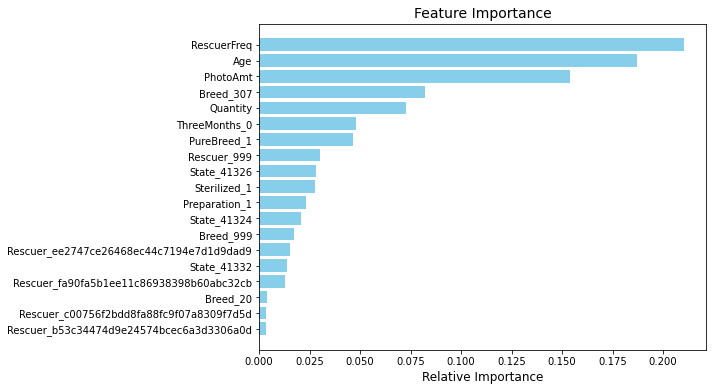

In [35]:
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])
sorted_idx.size
plt.figure(figsize=(8,6))
plt.barh(pos, feature_importance[sorted_idx], align='center',color='skyblue')
plt.yticks(pos, X_train_dog.columns[sorted_idx])
plt.xlabel('Relative Importance',fontsize=12)
plt.title('Feature Importance', fontsize=14)
plt.show()

### Feature importance for cat adoption

In [36]:
feature_importance = model_cat.feature_importances_
df= pd.DataFrame({'feature':X_train_cat.columns,'importance':feature_importance}).sort_values('importance',ascending=False)
df_new=df.sort_values(by=['importance'], ascending=False)
df_new

,feature,importance
5,RescuerFreq,0.215015
0,Age,0.181930
1,DescNumWords,0.149317
2,PhotoAmt,0.124755
10,ThreeMonths_1,0.091290
4,Quantity,0.075142
9,Sterilized_1,0.034975
8,State_41326,0.027719
6,Rescuer_999,0.027149
11,Vaccinated_1,0.019175


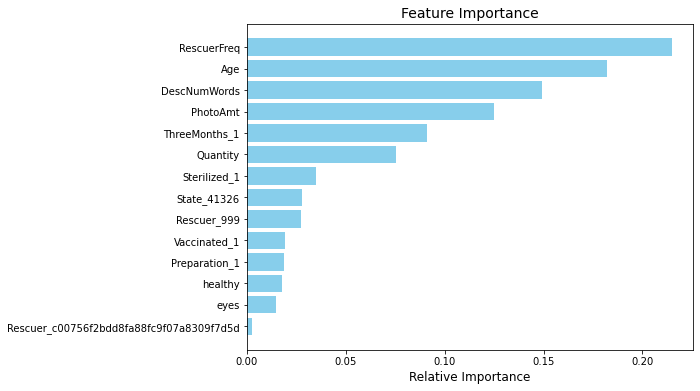

In [37]:
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0])
sorted_idx.size
plt.figure(figsize=(8,6))
plt.barh(pos, feature_importance[sorted_idx], align='center',color='skyblue')
plt.yticks(pos, X_train_cat.columns[sorted_idx])
plt.xlabel('Relative Importance',fontsize=12)
plt.title('Feature Importance', fontsize=14)
plt.show()

## SHAP analysis

### SHAP analysis for dog adoption

In [38]:
explainer_dog = shap.TreeExplainer(model_dog)
shap_values_dog = explainer_dog.shap_values(X_train_dog)

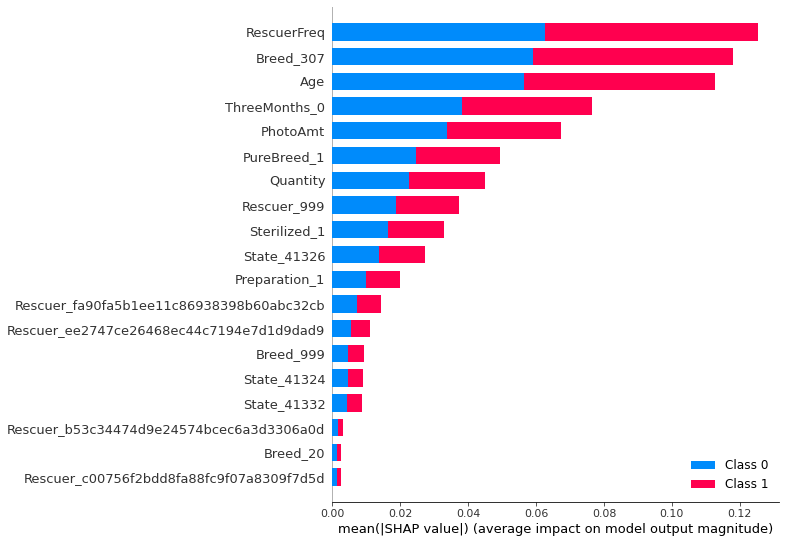

In [39]:
shap.summary_plot(shap_values_dog, X_train_dog, plot_type="bar")

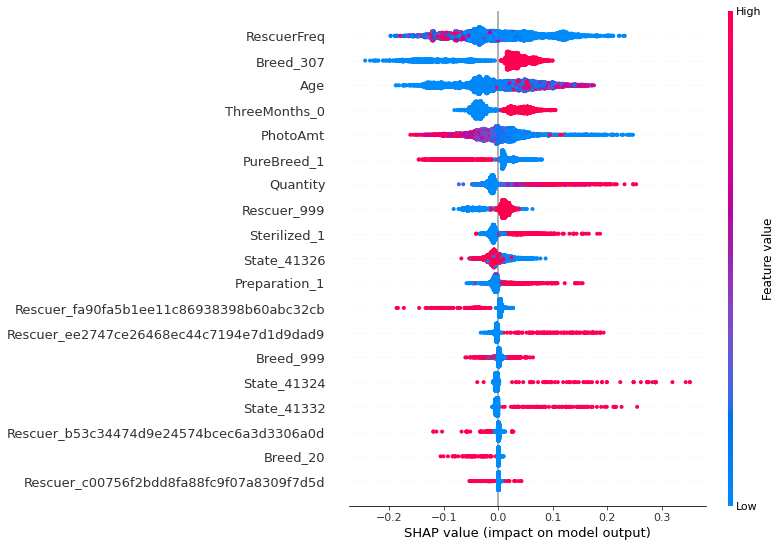

In [40]:
shap.summary_plot(shap_values_dog[1], X_train_dog)

We can describe the model. A adoption made within 100 days (low feature value) is associated with the following characteristics:
<br>
<ul>
    <li> Young age </li>
    <li> Dominant breed is not 307 (i.e. not mixed breed) </li>
    <li> Smaller quantity of dogs in the listing </li>
    <li> High number of photos </li>
    <li> Is not sterilized </li>
    <li> Is pure breed </li>
    <li> Is in state 41326 </li>
    <li> Has 2 fur colors </li>
    <li> Is not in State_413727 </li>
    <li> Is not vaccinated </li>
    <li> Is in state 41324 </li>
    <li> Is in state 41332 </li>
    <li> Is of breed 999 </li>
    <li> Is of breed 109 </li>
    <li> Is of breed 189 </li>
    <li> Is of breed 205 </li>
    <li> Is of breed 20 </li>
    <li> Is of breed 218 </li>
</ul>

### SHAP analysis for cat adoption

In [41]:
explainer_cat = shap.TreeExplainer(model_cat)
shap_values_cat = explainer_cat.shap_values(X_train_cat)

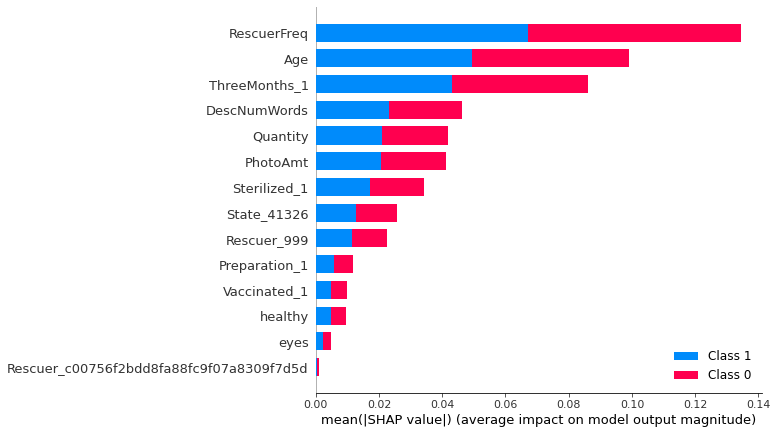

In [42]:
shap.summary_plot(shap_values_cat, X_train_cat, plot_type="bar")

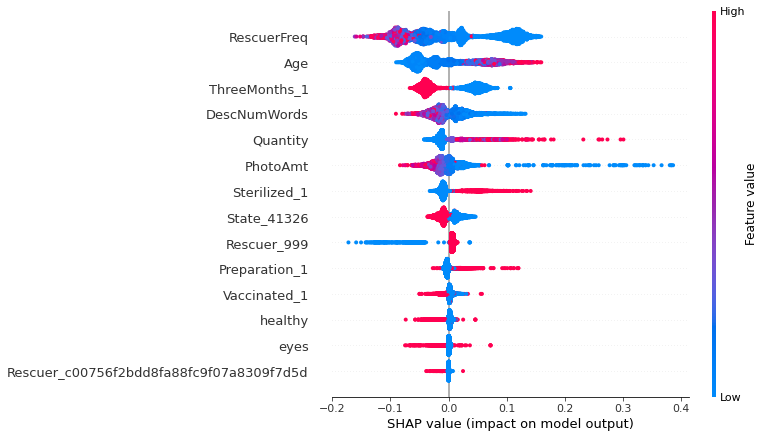

In [43]:
shap.summary_plot(shap_values_cat[1], X_train_cat)

We can describe the model. A adoption made within 100 days is associated with the following characteristics:

<br>
<ul>
    <li> Young age </li>
    <li> High photo amount </li>
    <li> Is not sterilized </li>
    <li> Smaller quanity of cats in each listing </li>
    <li> Is pure breed </li>
    <li> Is not of color 1 </li>
    <li> Is in state 41326 </li>
    <li> Is of breed 264 </li>
    <li> Is vaccinated </li>
    <li> Is in the top 7 states </li>
    <li> Is not in state 41330 </li>
    <li> Is not of breed 283</li>
</ul>

## Dependence plots

### Dependence plots for dog adoption

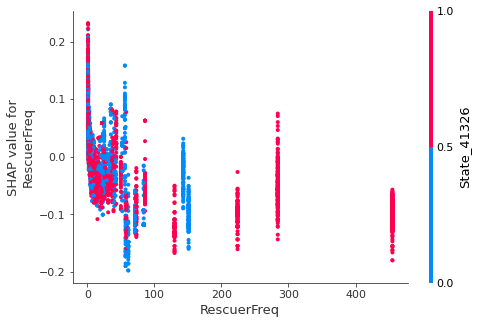

In [44]:
shap.dependence_plot("RescuerFreq", shap_values_dog[1], X_train_dog, interaction_index="State_41326")

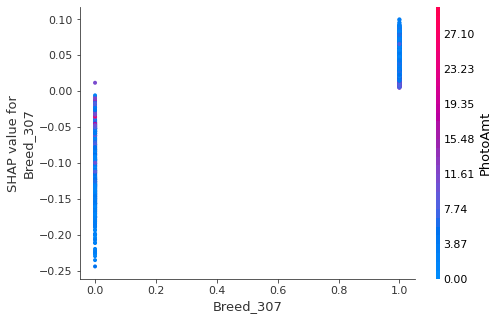

In [45]:
shap.dependence_plot("Breed_307", shap_values_dog[1], X_train_dog, interaction_index="PhotoAmt")

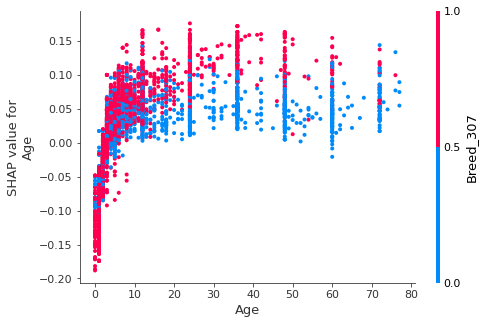

In [46]:
shap.dependence_plot("Age", shap_values_dog[1], X_train_dog)

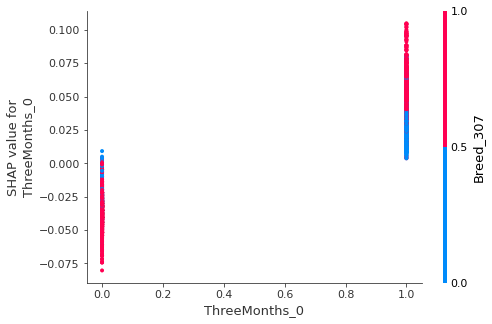

In [47]:
shap.dependence_plot("ThreeMonths_0", shap_values_dog[1], X_train_dog)

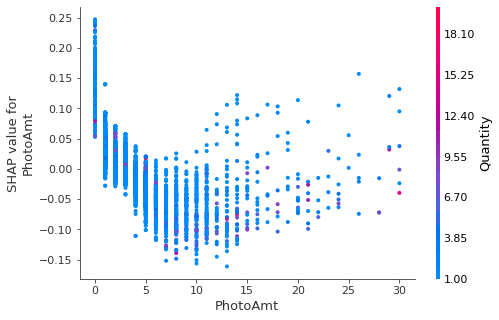

In [48]:
shap.dependence_plot("PhotoAmt", shap_values_dog[1], X_train_dog, interaction_index="Quantity")

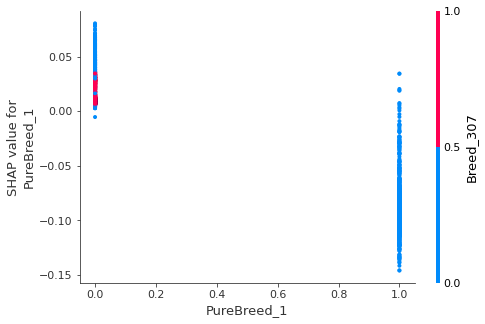

In [49]:
shap.dependence_plot("PureBreed_1", shap_values_dog[1], X_train_dog, interaction_index="Breed_307")

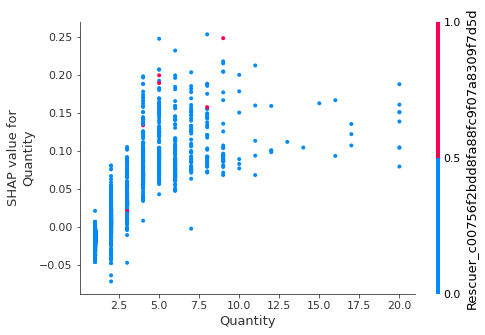

In [50]:
shap.dependence_plot("Quantity", shap_values_dog[1], X_train_dog, interaction_index="Rescuer_c00756f2bdd8fa88fc9f07a8309f7d5d")

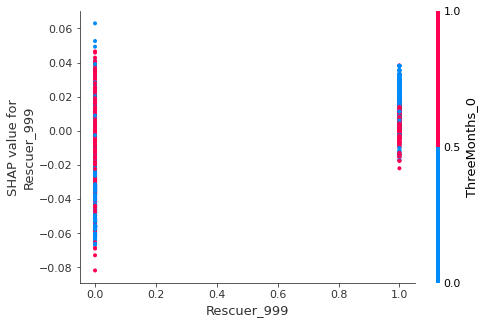

In [51]:
shap.dependence_plot("Rescuer_999", shap_values_dog[1], X_train_dog)

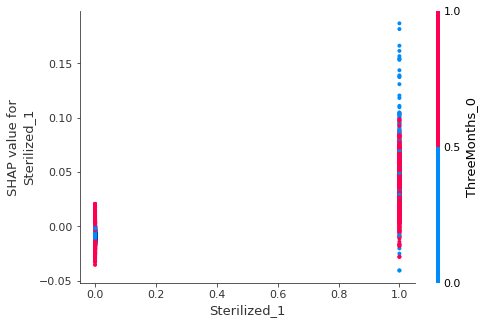

In [52]:
shap.dependence_plot("Sterilized_1", shap_values_dog[1], X_train_dog)

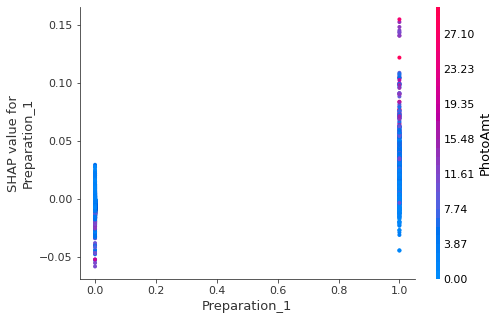

In [53]:
shap.dependence_plot("Preparation_1", shap_values_dog[1], X_train_dog)

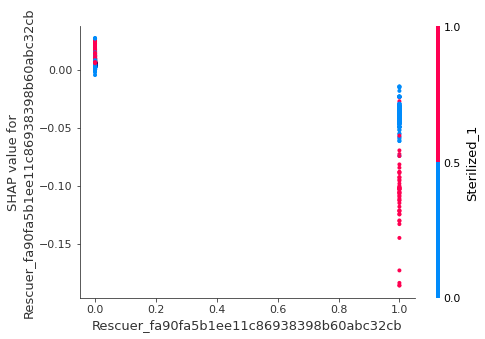

In [54]:
shap.dependence_plot("Rescuer_fa90fa5b1ee11c86938398b60abc32cb", shap_values_dog[1], X_train_dog)

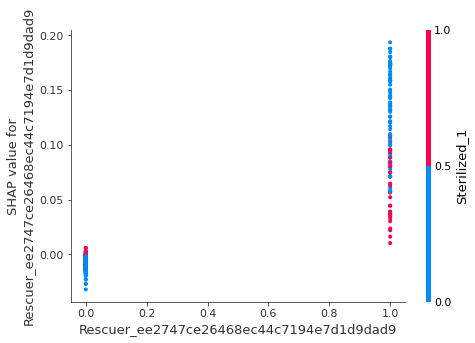

In [55]:
shap.dependence_plot("Rescuer_ee2747ce26468ec44c7194e7d1d9dad9", shap_values_dog[1], X_train_dog, interaction_index="Sterilized_1")

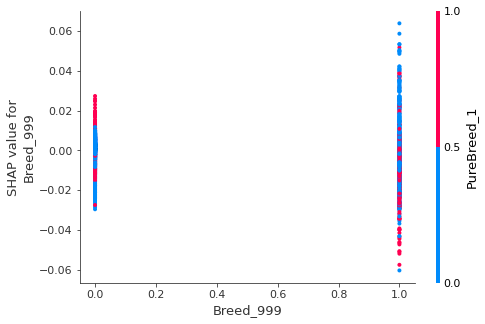

In [56]:
shap.dependence_plot("Breed_999", shap_values_dog[1], X_train_dog, interaction_index="PureBreed_1")

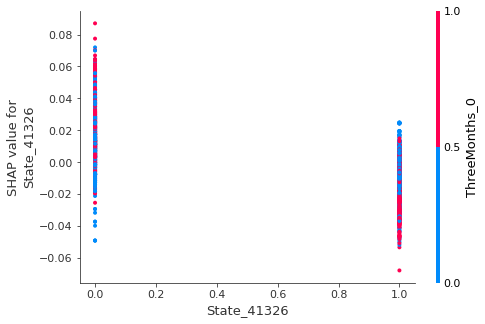

In [57]:
shap.dependence_plot("State_41326", shap_values_dog[1], X_train_dog)

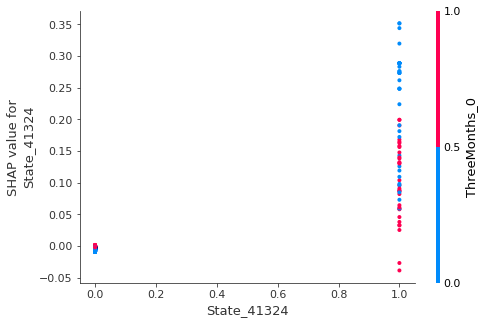

In [58]:
shap.dependence_plot("State_41324", shap_values_dog[1], X_train_dog)

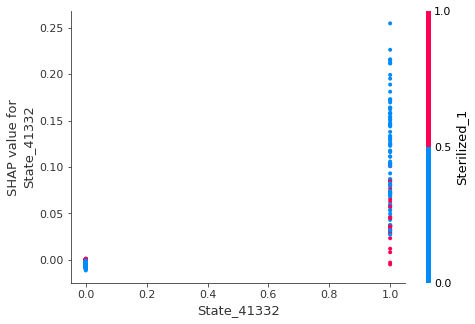

In [59]:
shap.dependence_plot("State_41332", shap_values_dog[1], X_train_dog)

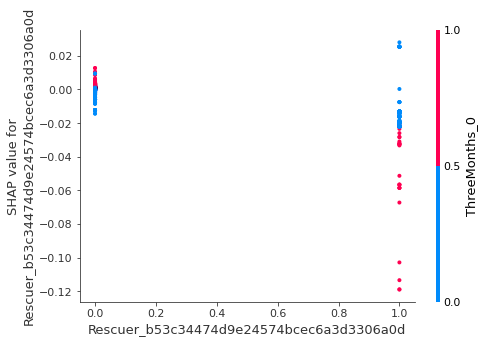

In [60]:
shap.dependence_plot("Rescuer_b53c34474d9e24574bcec6a3d3306a0d", shap_values_dog[1], X_train_dog)

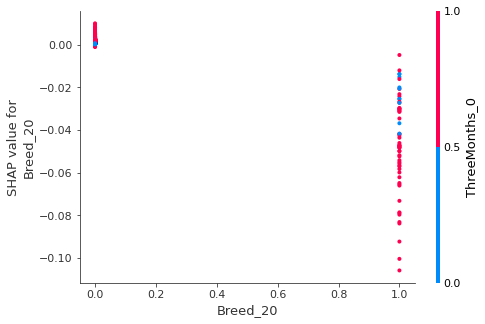

In [61]:
shap.dependence_plot("Breed_20", shap_values_dog[1], X_train_dog)

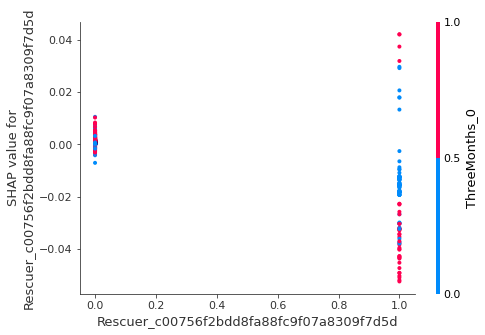

In [62]:
shap.dependence_plot("Rescuer_c00756f2bdd8fa88fc9f07a8309f7d5d", shap_values_dog[1], X_train_dog, interaction_index = 'ThreeMonths_0')

### Dependence plots for cat adoption

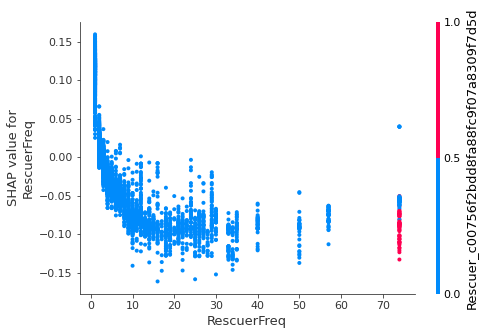

In [63]:
shap.dependence_plot("RescuerFreq", shap_values_cat[1], X_train_cat, interaction_index = 'Rescuer_c00756f2bdd8fa88fc9f07a8309f7d5d')

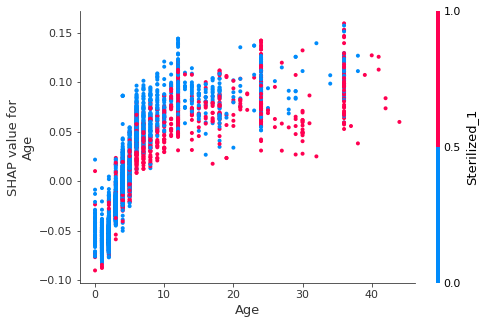

In [64]:
shap.dependence_plot("Age", shap_values_cat[1], X_train_cat, interaction_index = 'Sterilized_1')

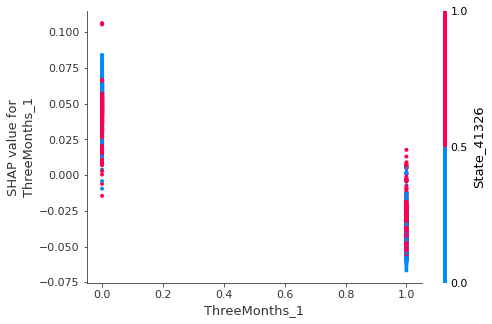

In [65]:
shap.dependence_plot("ThreeMonths_1", shap_values_cat[1], X_train_cat)

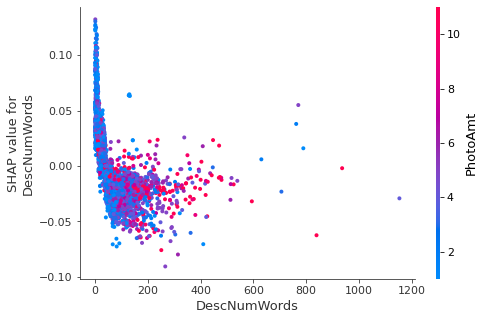

In [66]:
shap.dependence_plot("DescNumWords", shap_values_cat[1], X_train_cat, interaction_index = 'PhotoAmt')

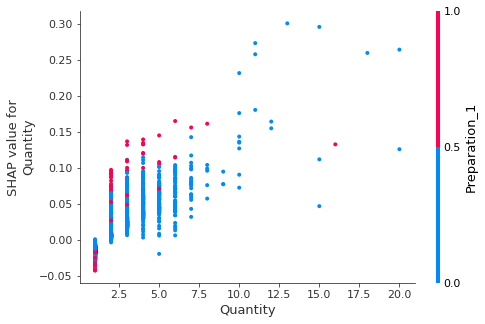

In [67]:
shap.dependence_plot("Quantity", shap_values_cat[1], X_train_cat, interaction_index = 'Preparation_1')

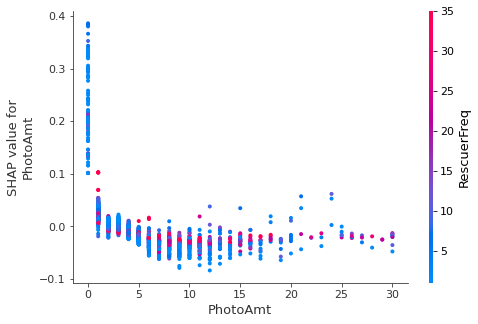

In [68]:
shap.dependence_plot("PhotoAmt", shap_values_cat[1], X_train_cat)

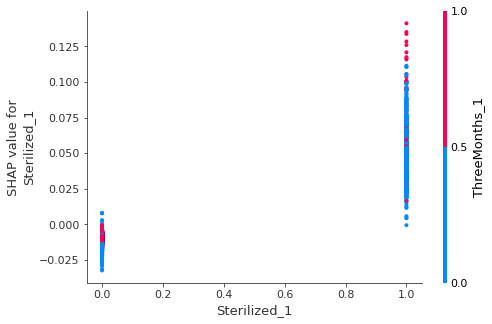

In [69]:
shap.dependence_plot("Sterilized_1", shap_values_cat[1], X_train_cat)

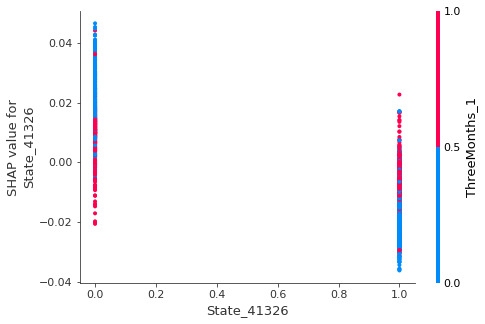

In [70]:
shap.dependence_plot("State_41326", shap_values_cat[1], X_train_cat)

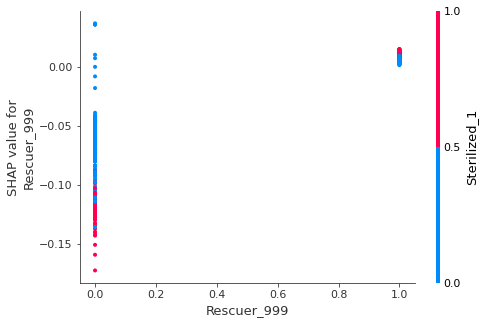

In [71]:
shap.dependence_plot("Rescuer_999", shap_values_cat[1], X_train_cat)

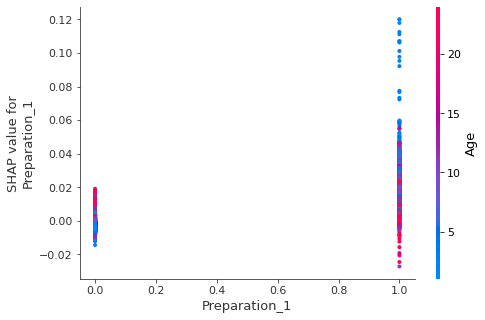

In [72]:
shap.dependence_plot("Preparation_1", shap_values_cat[1], X_train_cat)

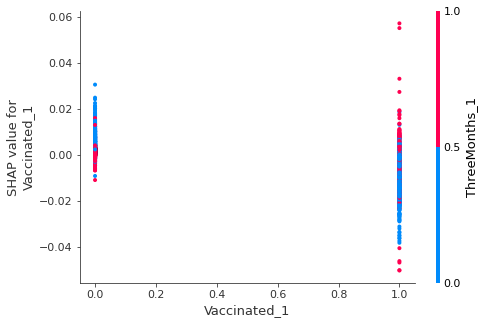

In [73]:
shap.dependence_plot("Vaccinated_1", shap_values_cat[1], X_train_cat)

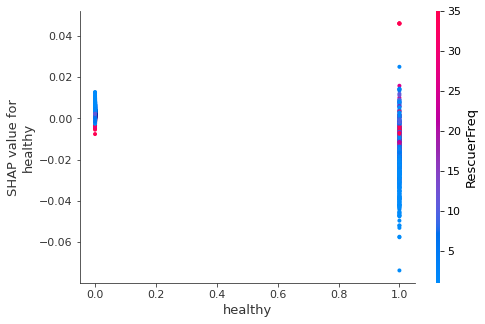

In [74]:
shap.dependence_plot("healthy", shap_values_cat[1], X_train_cat)

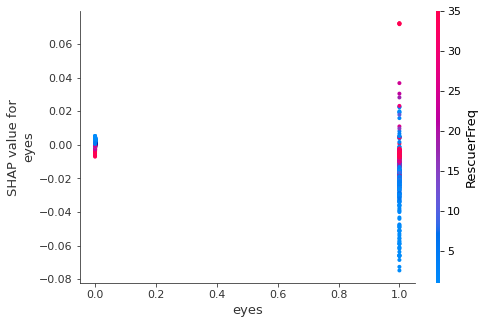

In [75]:
shap.dependence_plot("eyes", shap_values_cat[1], X_train_cat)

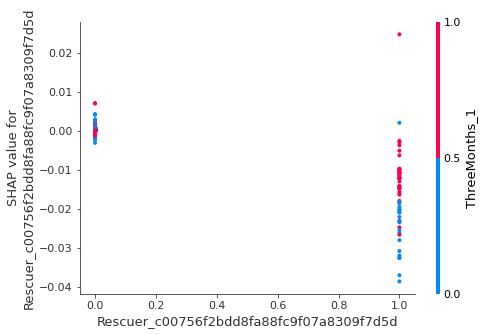

In [76]:
shap.dependence_plot("Rescuer_c00756f2bdd8fa88fc9f07a8309f7d5d", shap_values_cat[1], X_train_cat)

## Force plots

### Force plot for dog adoption

In [77]:
y_train_dog.mean()

0.29495934959349596

In [78]:
X_test_dog.iloc[[0]]

,Age,Breed_20,Breed_307,Breed_999,PhotoAmt,Preparation_1,PureBreed_1,Quantity,RescuerFreq,Rescuer_999,Rescuer_b53c34474d9e24574bcec6a3d3306a0d,Rescuer_c00756f2bdd8fa88fc9f07a8309f7d5d,Rescuer_ee2747ce26468ec44c7194e7d1d9dad9,Rescuer_fa90fa5b1ee11c86938398b60abc32cb,State_41324,State_41326,State_41332,Sterilized_1,ThreeMonths_0
PetID,,,,,,,,,,,,,,,,,,,
e63eea2f7,6,0,1,0,2,0,0,1,2,1,0,0,0,0,0,0,0,0,1


In [79]:
shap.initjs()
chosen_instance = X_test_dog.iloc[0,:]
shap_values = explainer_dog.shap_values(chosen_instance)
shap.force_plot(explainer_dog.expected_value[1], shap_values[1], chosen_instance)

In [80]:
X_test_dog.iloc[[1200]]

,Age,Breed_20,Breed_307,Breed_999,PhotoAmt,Preparation_1,PureBreed_1,Quantity,RescuerFreq,Rescuer_999,Rescuer_b53c34474d9e24574bcec6a3d3306a0d,Rescuer_c00756f2bdd8fa88fc9f07a8309f7d5d,Rescuer_ee2747ce26468ec44c7194e7d1d9dad9,Rescuer_fa90fa5b1ee11c86938398b60abc32cb,State_41324,State_41326,State_41332,Sterilized_1,ThreeMonths_0
PetID,,,,,,,,,,,,,,,,,,,
afa1e2afb,2,0,0,0,10,0,0,1,86,0,0,0,0,0,0,1,0,0,0


In [81]:
chosen_instance = X_test_dog.iloc[[1200]]
shap_values = explainer_dog.shap_values(chosen_instance)
shap.force_plot(explainer_dog.expected_value[1], shap_values[1], chosen_instance)

### Force plot for cat adoption

In [82]:
y_train_cat.mean()

0.25665399239543724

In [83]:
X_test_cat.iloc[[0]]

,Age,DescNumWords,PhotoAmt,Preparation_1,Quantity,RescuerFreq,Rescuer_999,Rescuer_c00756f2bdd8fa88fc9f07a8309f7d5d,State_41326,Sterilized_1,ThreeMonths_1,Vaccinated_1,eyes,healthy
PetID,,,,,,,,,,,,,,
c4835ee5c,2,19,4,0,1,3,1,0,1,0,1,0,0,0


In [84]:
chosen_instance = X_test_cat.iloc[[0]]
shap_values = explainer_cat.shap_values(chosen_instance)
shap.force_plot(explainer_cat.expected_value[1], shap_values[1], chosen_instance)

In [85]:
X_test_cat.iloc[[1200]]

,Age,DescNumWords,PhotoAmt,Preparation_1,Quantity,RescuerFreq,Rescuer_999,Rescuer_c00756f2bdd8fa88fc9f07a8309f7d5d,State_41326,Sterilized_1,ThreeMonths_1,Vaccinated_1,eyes,healthy
PetID,,,,,,,,,,,,,,
796781fbb,4,11,1,0,1,4,1,0,0,0,0,0,0,0


In [86]:
chosen_instance = X_test_cat.iloc[[1200]]
shap_values = explainer_cat.shap_values(chosen_instance)
shap.force_plot(explainer_cat.expected_value[1], shap_values[1], chosen_instance)